In [32]:
#imports for the project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as dat
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from yahoo_fin import stock_info as si
import ssl
from xgboost.sklearn import XGBClassifier 

# enable access to online data download
ssl._create_default_https_context = ssl._create_unverified_context


# Get the stock tickers from S&P 500 
df1 = pd.DataFrame( si.tickers_sp500() )


# Also get the tickers of popular stocks and include in the dataset
key_tickers = ['GOOG','AMZN','MSFT','AAPL','TSLA','FB','COST','HD','HOOD','NFLX','TGT','WMT','TWTR','F','DIS','IBM','BAC','BABA']

# Keeping the counts of stock companies to 100 to reduce the running time of the application
sp_100 = df1.head(100)
  
# include the 100 stocks in set    
sym1 = set( symbol for symbol in sp_100[0].values.tolist())

# include the popular stocks in set
sym3 = set( symbol for symbol in key_tickers )

# Union the popular stocks and the 100 stocks to remove duplicates. 
symbols = set.union(sym1,sym3)

# Provide the data source for the stocks data and the date range. Here 1 year of stock data is extracted. 
data_source = 'yahoo'
start_date = '2021-04-01'
end_date = '2022-04-29'

ticker_dfs = []

# download the stocks data in dataframe. Include the stock only if it is available for the given date range
count = 0
for ticker in symbols:
    try:
        temp = dat.DataReader(ticker, data_source, start_date, end_date)
        count = count + 1
        print("download complete for: " + str(count))
        if start_date in temp.index and end_date in temp.index:
            ticker_dfs.append(dat.DataReader(ticker, data_source, start_date, end_date))
    except KeyError as err:
        print("Oops!  That was key error for : " + str(ticker))




download complete for: 1
download complete for: 2
download complete for: 3
download complete for: 4
download complete for: 5
download complete for: 6
download complete for: 7
download complete for: 8
download complete for: 9
download complete for: 10
download complete for: 11
download complete for: 12
download complete for: 13
download complete for: 14
download complete for: 15
download complete for: 16
download complete for: 17
download complete for: 18
download complete for: 19
download complete for: 20
download complete for: 21
download complete for: 22
download complete for: 23
download complete for: 24
download complete for: 25
download complete for: 26
download complete for: 27
download complete for: 28
download complete for: 29
download complete for: 30
download complete for: 31
download complete for: 32
download complete for: 33
download complete for: 34
download complete for: 35
download complete for: 36
download complete for: 37
download complete for: 38
download complete for

In [33]:
# Methods to calculate features and labels

#calculate the gain
def gain(df,rolling_window,days,weight):
    #replacing the space in the columns of datasets
    df.columns = df.columns.str.replace(' ', '')

    #calculate moving average
    moving_average = df.rolling(rolling_window).mean()
    date_compare = (date.today() - timedelta(2 + days))
    # to accomodate holdidays and weekends, I reduce the reference date to one every time if the 
    # stock value not present for the given day.
    try:
        if str(date_compare) in df.index:
            meanvalue = moving_average.loc[str(date_compare)]
            regular_value = df.loc[str(date_compare)]
            gain = (regular_value.AdjClose - meanvalue.AdjClose) * 100 / meanvalue.AdjClose
        elif str(date_compare - timedelta(1)) in df.index:
            meanvalue = moving_average.loc[str(date_compare - timedelta(1))]
            regular_value = df.loc[str(date_compare - timedelta(1))]
            gain = (regular_value.AdjClose - meanvalue.AdjClose) * 100 / meanvalue.AdjClose
        elif str(date_compare - timedelta(2)) in df.index:
            meanvalue = moving_average.loc[str(date_compare - timedelta(2))]
            regular_value = df.loc[str(date_compare - timedelta(2))]
            gain = (regular_value.AdjClose - meanvalue.AdjClose) * 100 / meanvalue.AdjClose
        elif str(date_compare - timedelta(3)) in df.index:
            meanvalue = moving_average.loc[str(date_compare - timedelta(3))]
            regular_value = df.loc[str(date_compare - timedelta(3))]
            gain = (regular_value.AdjClose - meanvalue.AdjClose) * 100 / meanvalue.AdjClose
        else:
            meanvalue = moving_average.loc[str(date_compare - timedelta(4))]
            regular_value = df.loc[str(date_compare - timedelta(4))]
            gain = (regular_value.AdjClose - meanvalue.AdjClose) * 100 / meanvalue.AdjClose
    except KeyError as err:
        print("Oops! gain can't be calculated for date: " + str(date_compare) + " ticker is : " + str(ticker))

    return feature_gain(gain,weight)


# Normalize the gain value to range of -1 to 1
def feature_gain(gain,weight):
    if gain > 0:
        feature_gain = 1*weight
    elif gain < 0:
        feature_gain = -1 * weight
    else:
        feature_gain = 0
    return feature_gain


# volatility calculation

def volatility(df,rolling_window,days,weight):
    # replace spaces in the columns
    df.columns = df.columns.str.replace(' ', '')
    
    # calculate moving average
    moving_average = df.rolling(rolling_window).mean()
    
    # date range 
    date_from = date.today()
    date_to = (date.today() - timedelta(days))

    date_temp = date_from
    sum= 0
    sum_adjClose = 0
    count = 0
    # while in the date range
    while date_temp >= date_to:
        # include only if stock value available for the date
        if str(date_temp) in df.index:
            # calculate mean and adjusted close price for the date_temp date
            meanvalue = moving_average.loc[str(date_temp)]
            regular_value = df.loc[str(date_temp)]
            
            # get square of sum of difference between adjusted close and mean values
            sum = sum + ((regular_value.AdjClose - meanvalue.AdjClose) ** 2)
            
            #get sum of adjusted close price for the same days 
            sum_adjClose = sum_adjClose + regular_value.AdjClose
            count = count + 1
        date_temp = date_temp - timedelta(1)

    # calculate the volatility 
    
    volatility = sum/sum_adjClose
    if(volatility < 0.5):
        return 1 * weight
    else:
        return -1 * weight

# Label calculation for the given feature value for Random Forests
def suggest(feature_value):
    suggest = ""
    if feature_value > 1:
        suggest = "buy"
    elif feature_value > 0 and feature_value < 1:
        suggest = "hold"
    else :
        suggest = "sell"
    return suggest

# Label calculation for the given feature value for Gradient Boosting Classfier
def suggest_gradientboosting(feature_value):
    suggest = ""
    if feature_value > 1:
        suggest = 2
    elif feature_value > 0 and feature_value < 1:
        suggest = 1
    else :
        suggest = 0
    return suggest


In [77]:
#feature data set calculation for Random Forests

feature_list = []

# calculate Label and set the features in the datasets
for ticker in ticker_dfs:
    try:
        feature_value = gain(ticker,7,0,1) + gain(ticker,7,7,.9) + gain(ticker,7,28,.75) + gain(ticker,7,365,.25) + volatility(ticker,7,0,.5) + volatility(ticker,7,7,.75)+ volatility(ticker,7,28,.9) + volatility(ticker,7,365,1)
        feature_list.append([gain(ticker,7,0,1),gain(ticker,7,7,.9),gain(ticker,7,28,.75),gain(ticker,7,365,.25),volatility(ticker,7,0,.5),volatility(ticker,7,7,.75),volatility(ticker,7,28,.9),volatility(ticker,7,365,1),suggest(feature_value)])
    except KeyError as err:
        print("Oops!  That was key error for : " + str(ticker))

# create the labels of the features 
df = pd.DataFrame(feature_list, columns = ['gain_current','gain_1_week', 'gain_4_weeks','gain_1_year','volatility_current','volatility_1_week','volatility_4_weeks','volatility_1_year','suggest'])

# drop the output label from the feature set for training
X = df.drop(['suggest'],axis=1)
Y = df['suggest']

# create the training and test datasets with 80% as training and 20% as test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


# create the random forest classifier

rnd_clf = RandomForestClassifier(n_estimators = 400,
                                 max_leaf_nodes = 16,
                                 n_jobs = -1)

# create the model with the fit method and training dataset.
rnd_clf.fit(x_train, y_train)

# predict the model with the test dataset
y_pred = rnd_clf.predict(x_test)

# Print the accuracy score of the model
print("Accuracy of Random Forest: " + str(accuracy_score(y_test, y_pred)))

# Get the feature importances in the model
important_features = pd.Series(rnd_clf.feature_importances_, index=X.columns).\
                        sort_values(ascending=False)

# print the feature importance in the model
print("feature importance:")
print(important_features)





Accuracy of Random Forest: 0.9565217391304348
Important_features:
gain_1_week           0.208019
volatility_1_week     0.207978
gain_4_weeks          0.143455
gain_current          0.127895
volatility_4_weeks    0.126876
volatility_1_year     0.096446
volatility_current    0.050586
gain_1_year           0.038744
dtype: float64


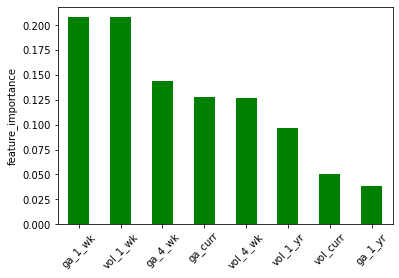

In [78]:
# To print the graph of feature importances for Random Forests Model

index_ = ['ga_1_wk','vol_1_wk', 'ga_4_wk','ga_curr','vol_4_wk', 'vol_1_yr',  'vol_curr',  'ga_1_yr' ]
  
# set the index
important_features.index = index_

ax = important_features.plot.bar(rot=45,color="Green")
ax.set_ylabel('feature_importance')
plt.show()

In [86]:
# #feature data set calculation for gradient Boosting Model

feature_list_GB = []
# calculate Label and set the features in the datasets
for ticker in ticker_dfs:
    try:
        feature_value = gain(ticker,7,0,1) + gain(ticker,7,7,.9) + gain(ticker,7,28,.75) + gain(ticker,7,365,.25) + volatility(ticker,7,0,.5) + volatility(ticker,7,7,.75)+ volatility(ticker,7,28,.9) + volatility(ticker,7,365,1)
        feature_list_GB.append([gain(ticker,7,0,1),gain(ticker,7,7,.9),gain(ticker,7,28,.75),gain(ticker,7,365,.25),volatility(ticker,7,0,.5),volatility(ticker,7,7,.75),volatility(ticker,7,28,.9),volatility(ticker,7,365,1),suggest_gradientboosting(feature_value)])
    except KeyError as err:
        print("Oops!  That was key error for : " + str(ticker))

# create the labels of the features 
df = pd.DataFrame(feature_list_GB, columns = ['gain_current','gain_1_week', 'gain_4_weeks','gain_1_year','volatility_current','volatility_1_week','volatility_4_weeks','volatility_1_year','suggest'])

# drop the output label from the feature set for training
X = df.drop(['suggest'],axis=1)
Y = df['suggest']

# create the training and test datasets with 80% as training and 20% as test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# create the gradient boosting classifier
gb_clf = XGBClassifier(n_estimators=400)

# create the model with the fit method and training dataset.
gb_clf.fit(x_train, y_train)

# predict the model with the test dataset
gb_clf.predict(x_test)

# Print the accuracy score of the model
print("Accuracy of gradient boosting:  " + str(gb_clf.score(x_test, y_test)))

# Get the feature importances in the model
important_features = pd.Series(gb_clf.feature_importances_, index=X.columns).\
                        sort_values(ascending=False)

# print the feature importance in the model
print("Important_features:")
print(important_features)

Accuracy of gradient boosting:  1.0
Important_features:
volatility_1_year     0.366585
gain_current          0.266520
volatility_current    0.143979
volatility_1_week     0.114214
volatility_4_weeks    0.073926
gain_4_weeks          0.019539
gain_1_year           0.008086
gain_1_week           0.007151
dtype: float32


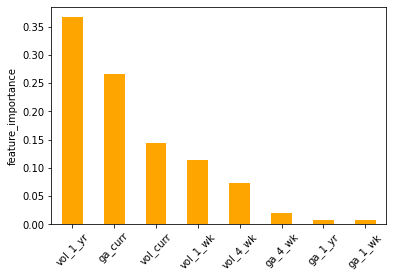

In [87]:
# To print the graph of feature importances for Gradient Boosting Classifier

index_ = ['vol_1_yr','ga_curr','vol_curr','vol_1_wk','vol_4_wk',  'ga_4_wk','ga_1_yr',   'ga_1_wk']
  
# set the index
important_features.index = index_

ax = important_features.plot.bar(rot=45,color="Orange")
ax.set_ylabel('feature_importance')
plt.show()